In [1]:
import itertools
import dataclasses
from typing import List, Sequence, Set

import libmambapy

import mamba_error_reporting as mer

# Problem definition

## PubGrub Example

The example given by Natalie Weizenbaum (image credits https://nex3.medium.com/pubgrub-2fb6470504f)

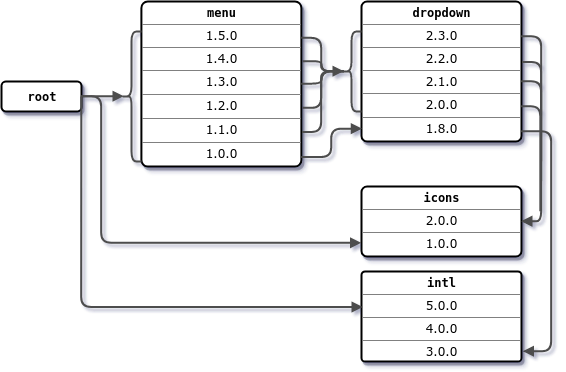

### Ideal output (from PubGrub)
```
Because dropdown >=2.0.0 depends on icons >=2.0.0 and root depends
  on icons <2.0.0, dropdown >=2.0.0 is forbidden.

And because menu >=1.1.0 depends on dropdown >=2.0.0, menu >=1.1.0
  is forbidden.

And because menu <1.1.0 depends on dropdown >=1.0.0 <2.0.0 which
  depends on intl <4.0.0, every version of menu requires intl
  <4.0.0.

So, because root depends on both menu >=1.0.0 and intl >=5.0.0,
  version solving failed.
```

# Conflict analysis

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
solver, pool = mer.problems.create_pubgrub()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - package menu-1.0.0 requires dropdown 1.**, but none of the providers can be installed
   


In [4]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

In [5]:
pbs

,type,source_id,source_is_pkg,dependency,dependency_id,target_id,target_is_pkg,explanation
0,SolverRuleinfo.SOLVER_RULE_JOB,0,False,menu,203,259,False,conflicting requests
1,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,7,True,dropdown 1.**,-2147483641,0,False,"package menu-1.0.0 requires dropdown 1.**, but..."
2,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,2,True,dropdown 2.**,-2147483647,0,False,"package menu-1.5.0 requires dropdown 2.**, but..."
3,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,3,True,dropdown 2.**,-2147483647,0,False,"package menu-1.4.0 requires dropdown 2.**, but..."
4,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,4,True,dropdown 2.**,-2147483647,0,False,"package menu-1.3.0 requires dropdown 2.**, but..."
5,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,5,True,dropdown 2.**,-2147483647,0,False,"package menu-1.2.0 requires dropdown 2.**, but..."
6,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,6,True,dropdown 2.**,-2147483647,0,False,"package menu-1.1.0 requires dropdown 2.**, but..."
7,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,12,True,intl 3.**,-2147483633,0,False,"package dropdown-1.8.0 requires intl 3.**, but..."
8,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,8,True,icons 2.**,-2147483639,0,False,"package dropdown-2.3.0 requires icons 2.**, bu..."
9,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,9,True,icons 2.**,-2147483639,0,False,"package dropdown-2.2.0 requires icons 2.**, bu..."


In [6]:
deps

,dependency_id,solvable_id
0,203,2
1,203,3
2,203,4
3,203,5
4,203,6
5,203,7
6,-2147483641,12
7,-2147483647,8
8,-2147483647,9
9,-2147483647,10


In [7]:
solvables

,name,version,build_string,build_number
id,,,,
2,menu,1.5.0,,0
3,menu,1.4.0,,0
4,menu,1.3.0,,0
5,menu,1.2.0,,0
6,menu,1.1.0,,0
7,menu,1.0.0,,0
8,dropdown,2.3.0,,0
9,dropdown,2.2.0,,0
10,dropdown,2.1.0,,0


In [8]:
def build_problem_graph_solvable(pbs, solvables, deps):
    g = nx.DiGraph()
    
    # All solvables
    for solv_id, solv_info in solvables.iterrows():
        g.add_node(solv_id, **solv_info, repr="{name}-{version}-{build_string}".format(**solv_info))
       
    # TODO include other JOBs
    # TODO figure what to do with dependency with null source
    pbs_with_deps = pbs[pbs.type.isin([libmambapy.SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES])]
    pbs_with_deps = pbs_with_deps.join(deps.set_index("dependency_id"), on="dependency_id")
    
    # All dependency edges
    for _, pb in pbs_with_deps.iterrows():
        g.add_edge(
            pb.source_id, pb.solvable_id,
            dependency_id=pb.dependency_id, dependency=pb.dependency
        )

    return g

In [9]:
def plot_dag(graph):
    plt.figure(figsize=(10, 6), dpi=300)

    # Position using levels
    pos = {}
    for level, nodes in enumerate(nx.topological_generations(graph)):
        pos.update({n: (x, -level) for x, n in enumerate(nodes)})

    options = {"node_size": 800, "alpha": 0.5}
    nx.draw_networkx_nodes(graph, pos, node_color="blue", **options)
    nx.draw_networkx_edges(graph, pos, **options)

    # some labels
    labels = {n: attr["repr"] for n, attr in graph.nodes.items()}
    # nx.draw_networkx_labels(g, pos, labels, font_size=22, font_color="whitesmoke")
    nx.draw_networkx_labels(graph, pos, labels, font_size=7)

    plt.tight_layout()
    plt.axis("off")
    plt.show()

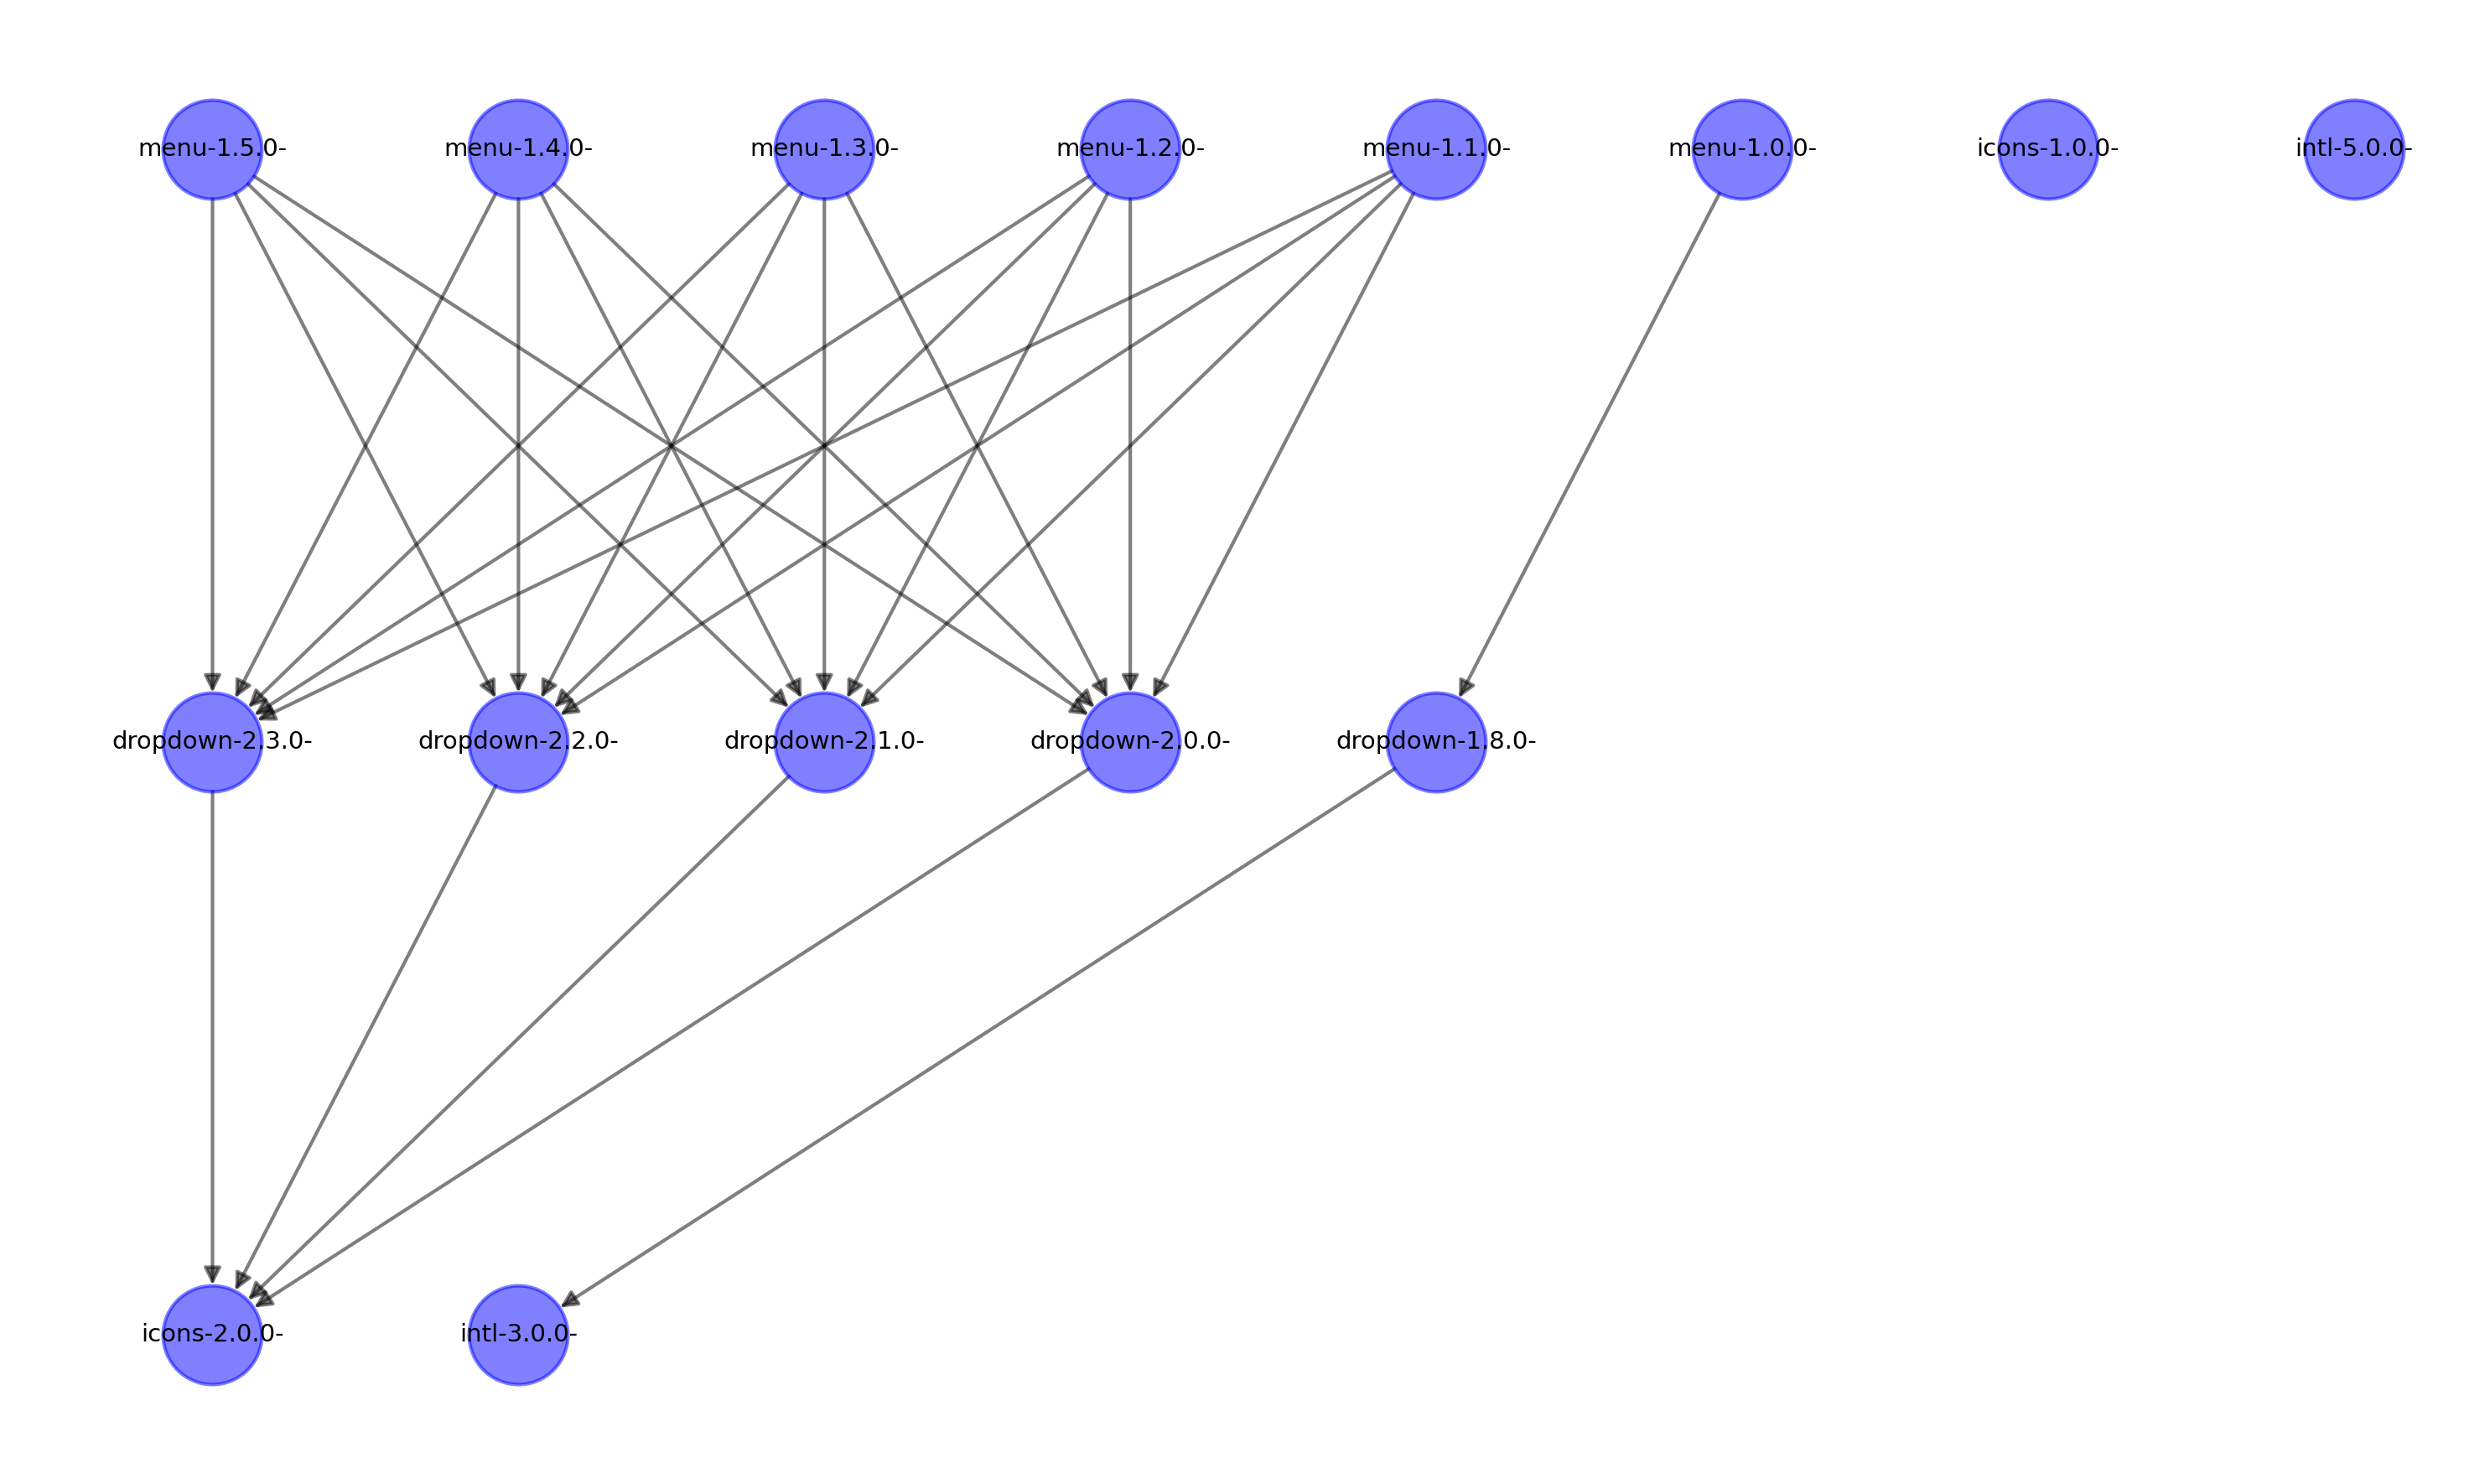

In [10]:
g = build_problem_graph_solvable(pbs, solvables, deps)
plot_dag(g)

In [11]:
def all_equal(*args):
    return all(a == b for a, b in itertools.pairwise(args))

assert all_equal()
assert all_equal(1)
assert all_equal(2, 2)
assert all_equal(2, 2, 2)
assert not all_equal(2, 2, 2, 1, 2)


@dataclasses.dataclass
class Dependency:
    id: int
    name: str
    parent_nodes: Set[str] = dataclasses.field(default_factory=set)
    solvable_nodes: Set[int] = dataclasses.field(default_factory=set)


# Kind of redundant function since we had that information in the dataframes.
def dependency_to_solvables(graph: nx.DiGraph) -> List[Dependency]:
    dependencies = {}
    for n, s in graph.edges:
        dep_id = graph.edges[(n, s)]["dependency_id"]
        dep_name = graph.edges[(n, s)]["dependency"]
        d = dependencies.setdefault(dep_id, Dependency(id=dep_id, name=dep_name))
        d.parent_nodes.add(n)
        d.solvable_nodes.add(s)
    return list(dependencies.values())


def compressable_dependencies(
    graph: nx.DiGraph, dependencies: Sequence[Dependency]
) -> List[Dependency]:
    return [
        d for d in dependencies
        if (len(d.solvable_nodes) > 1) and all_equal(*(list(graph.successors(n)) for n in d.solvable_nodes))
    ]


# TODO Must compress the case where different dependencies resolve to the same solvables
def compress_dependencies(graph: nx.DiGraph, deps):
    graph = graph.copy()
    to_compress = compressable_dependencies(graph, dependency_to_solvables(graph))
    for d in to_compress:
        # Add new dependency node and redirect dependency predecessor to it
        graph.add_node(d.id, repr=d.name, dependency=d.name)
        graph.add_edges_from((p, d.id) for p in d.parent_nodes)
        children = graph.successors(next(iter(d.solvable_nodes)))  # TODO does not work with empty
        graph.add_edges_from((d.id, c) for c in children)
        # Remove old edges, and solvable nodes that don't have parent
        graph.remove_edges_from((p, s) for s in d.solvable_nodes for p in d.parent_nodes)
        graph.remove_nodes_from(s for s in d.solvable_nodes if (graph.in_degree(s) == 0))
    return graph   

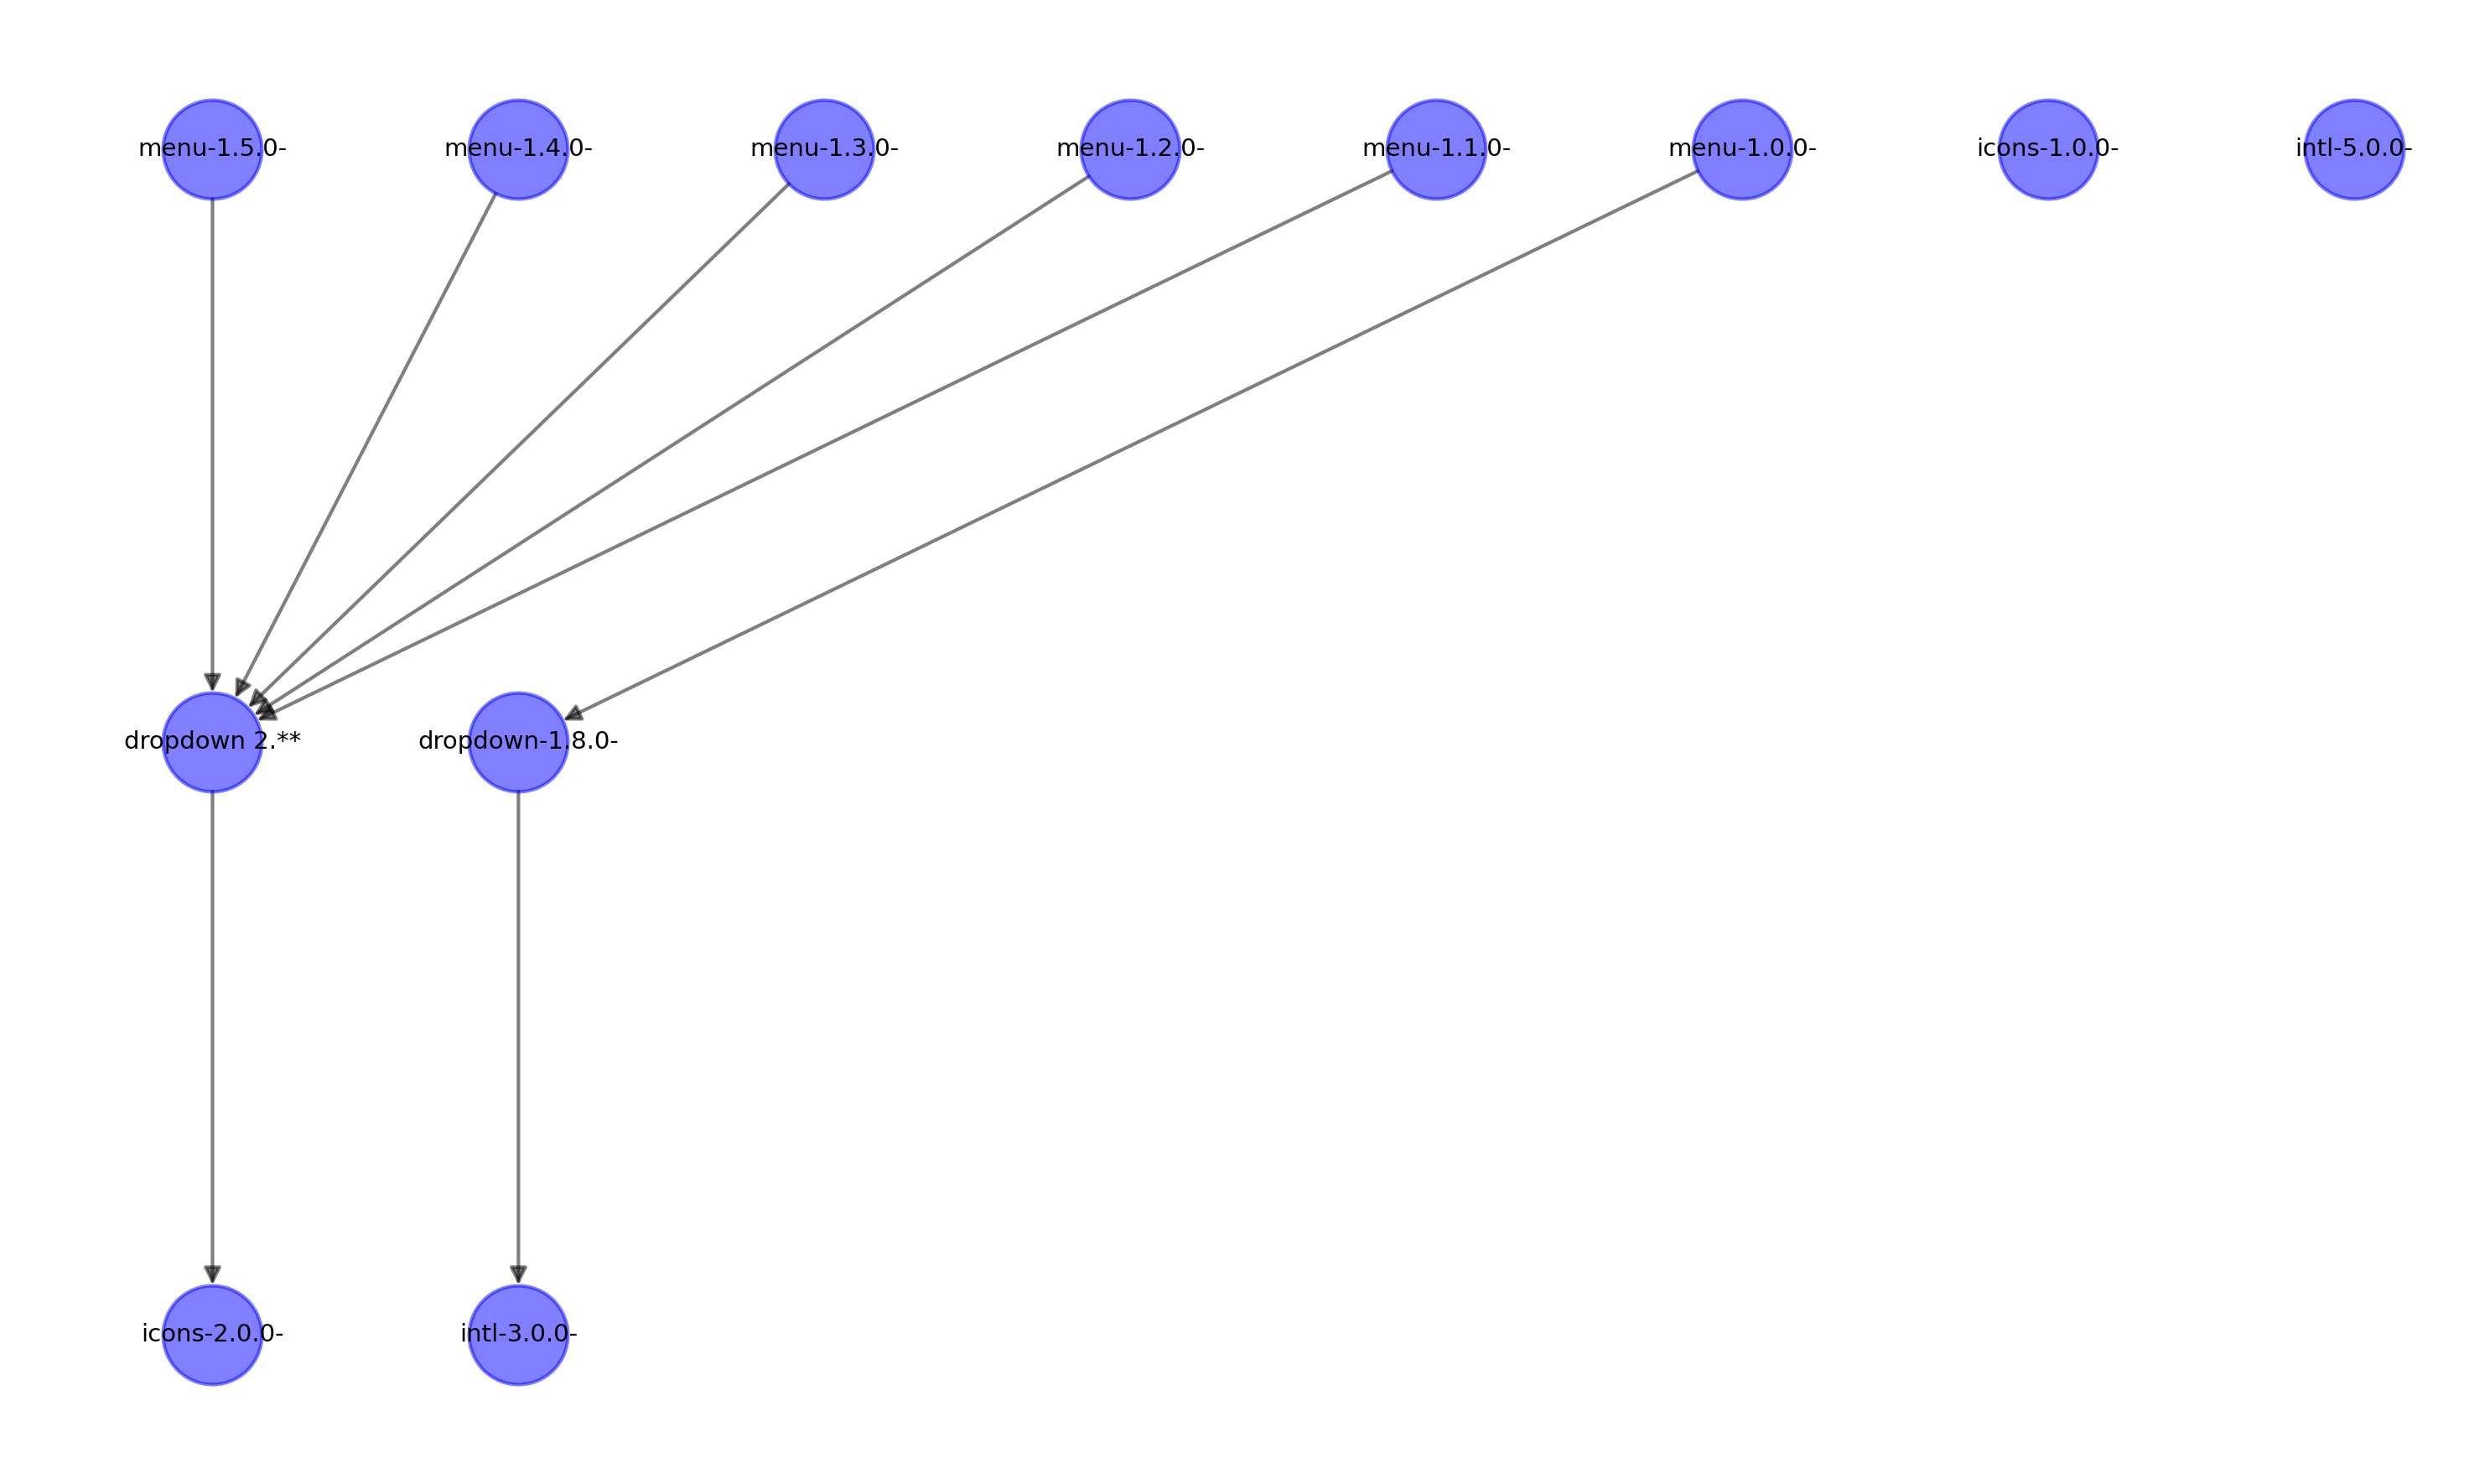

In [12]:
gc = compress_dependencies(g, deps)
plot_dag(gc)

In [13]:
def get_root_ancestor(graph, node):
    root_parents = set()
    visited = {node}
    while len(visited) > 0:
        n = visited.pop()
        parents = set(graph.predecessors(n))
        if len(parents) > 0:
            visited = visited.union(parents)
        else:
            root_parents.add(n)
    return root_parents

            
def explain_errors(graph):
    # leaves = [n for n in graph.nodes() if graph.in_degree(n) >= 1]
    leaves = [n for n in graph.nodes() if graph.out_degree(n) == 0 and graph.in_degree(n) >= 1]

    # print([str(graph.nodes[l]["pkg_info"]) for l in leaves])
    conflicts = {}
    for leaf in leaves:
        leaf_pkg_repr = "{name}-{version}-{build_string}".format(**graph.nodes[leaf])
        leaf_in_dependencies = set(
            graph.edges[e]["dependency"] for e in graph.in_edges(leaf)
        )
        
        ancestors = get_root_ancestor(graph, leaf)
        ancestor_pkg_repr = ["{name}-{version}-{build_string}".format(**graph.nodes[n]) for n in ancestors]
        ancestor_out_dependencies = set(
            graph.edges[e]["dependency"] for a in ancestors for e in graph.out_edges(a) 
        )
        print(f"Leaf: {leaf_pkg_repr}")
        print("  has dependencies " + " & ".join(leaf_in_dependencies))
        print(f"Ancestor: " + ", ".join(ancestor_pkg_repr))
        print("  has dependencies " + " & ".join(ancestor_out_dependencies))
        print()

In [14]:
explain_errors(g)

Leaf: icons-2.0.0-
  has dependencies icons 2.**
Ancestor: menu-1.5.0-, menu-1.4.0-, menu-1.3.0-, menu-1.2.0-, menu-1.1.0-
  has dependencies dropdown 2.**

Leaf: intl-3.0.0-
  has dependencies intl 3.**
Ancestor: menu-1.0.0-
  has dependencies dropdown 1.**

